## Transferência de Aprendizado e Fine-Tuning em Detecção de Imagens

### Transferência de Aprendizado

A transferência de aprendizado é uma técnica em aprendizado de máquina onde um modelo treinado em uma tarefa é reaproveitado em uma nova tarefa relacionada. Essa abordagem é particularmente útil em problemas de visão computacional, onde modelos complexos de redes neurais convolucionais (CNNs) são pré-treinados em grandes bases de dados, como o ImageNet, que contém milhões de imagens rotuladas.

**Principais Vantagens:**
- **Redução do Tempo de Treinamento:** Aproveitar um modelo pré-treinado reduz significativamente o tempo de treinamento, pois a rede já aprendeu a extrair características úteis de imagens.
- **Melhor Desempenho:** Modelos pré-treinados geralmente oferecem melhor desempenho, especialmente quando o conjunto de dados disponível para a nova tarefa é pequeno.

### Fine-Tuning

O fine-tuning é um passo posterior à transferência de aprendizado. Ele envolve ajustar os pesos do modelo pré-treinado para a nova tarefa específica, refinando ainda mais o modelo para melhorar seu desempenho.

**Processo de Fine-Tuning:**

1. **Selecionar um Modelo Pré-Treinado:** Escolher um modelo CNN que tenha sido previamente treinado em uma grande base de dados, como ResNet, VGG, ou Inception.
2. **Congelar Camadas Iniciais:** Inicialmente, as camadas convolucionais inferiores (que capturam características básicas como bordas e texturas) são "congeladas", ou seja, seus pesos não são ajustados durante o treinamento na nova tarefa.
3. **Substituir Camadas Superiores:** As camadas superiores (classificadores) do modelo são substituídas por novas camadas que correspondem à nova tarefa de detecção de imagens.
4. **Treinamento:** Treinar o modelo com a nova tarefa, ajustando os pesos das camadas superiores e, eventualmente, descongelando e ajustando algumas das camadas inferiores para melhorar a especialização na nova tarefa.

### Aplicação em Detecção de Imagens

Na detecção de imagens, o objetivo é não apenas classificar objetos em uma imagem, mas também localizar suas posições. A transferência de aprendizado e o fine-tuning são amplamente utilizados para essa finalidade:

1. **Modelo Base Pré-Treinado:** Utilizar um modelo como Faster R-CNN, YOLO ou SSD, que já foi treinado em uma grande base de dados de detecção de objetos.
2. **Adaptar para a Nova Tarefa:** Ajustar as camadas superiores do modelo para detectar as classes de objetos específicas do novo conjunto de dados.
3. **Treinamento e Fine-Tuning:** Treinar o modelo ajustado no novo conjunto de dados, realizando fine-tuning nas camadas superiores e, se necessário, em algumas das camadas convolucionais inferiores para melhorar a precisão na detecção.

### Benefícios na Detecção de Imagens

- **Eficiência:** Reduz a necessidade de grandes quantidades de dados rotulados, já que o modelo aproveita o conhecimento adquirido em grandes bases de dados.
- **Rapidez:** Acelera o desenvolvimento e implementação de sistemas de detecção de imagens.
- **Precisão:** Melhora a precisão na detecção de objetos, mesmo com conjuntos de dados relativamente pequenos.

Em resumo, a transferência de aprendizado e o fine-tuning são técnicas poderosas que facilitam o desenvolvimento de sistemas de detecção de imagens eficientes e precisos, aproveitando modelos pré-treinados e ajustando-os para tarefas específicas.

# Exemplo práticos

* Inserir o reconhecimento do Homer e Bart (Os Simpsons) utilizando a rede neural pré-treinada na base da dados ImageNet

# Imports

In [315]:
import os
import cv2
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from keras.api.models import Model
from keras.api.layers import Input, Dense, Conv2D, GlobalAveragePooling2D, Flatten, Dropout
from keras.api.applications import ResNet50
from keras.api.utils import plot_model

from keras.src.legacy.preprocessing.image import ImageDataGenerator

from utils.model_utils import salvar_modelo, print_history, plot_history

# Carregando o Dataset e tratando os dados

In [254]:
# Dataset: https://drive.google.com/drive/folders/1UBHOwVEyR5OXyWVHO-r2lviJy2Oz_Sqk

train_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
train_dataset = train_generator.flow_from_directory(
    os.path.join(os.getcwd(), 'datasets', 'simpsons_2', 'training_set'),
    target_size=(256, 256),
    batch_size=8,
    class_mode='categorical',
    shuffle=True
)

test_generator = ImageDataGenerator(rescale=1.0/255)
test_dataset = test_generator.flow_from_directory(
    os.path.join(os.getcwd(), 'datasets', 'simpsons_2', 'test_set'),
    target_size=(256, 256),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 215 images belonging to 2 classes.
Found 54 images belonging to 2 classes.


# Carregando a rede neural pré treinada (modelo base)

* Base referência: https://image-net.org/download.php
* Essa base foi treinada usando a arquitetura de CNN ResNet50
    * https://arxiv.org/pdf/1512.03385
    * Visualização: ./resources/ResNet50.png

In [261]:
model = ResNet50(
    weights='imagenet',
    include_top=False, # Carrega apenas as camadas convolucionais, não inclui camadas densas
    input_tensor=Input(shape=(256, 256, 3))
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [270]:
model.summary()
# plot_model(model, show_shapes=True)

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

# Configurando a rede

## Congelando os pesos da rede

In [268]:
# Cogelando o treinamento dos pesos para todas as camadas
for layer in model.layers:
    layer.trainable = False

## Criando camada customizada

In [271]:
# Acessando última camada do modelo (conv5_block3_3_conv)
model.output

<KerasTensor shape=(None, 8, 8, 2048), dtype=float32, sparse=False, name=keras_tensor_194>

In [272]:
output = model.output
# Reduz a dimensionalidade da camada (8, 8, 2048) para (2048)
global_pooling = GlobalAveragePooling2D()(output)
dense_1 = Dense(
    units=1025, activation='relu'
)(global_pooling)
dropout_1 = Dropout(0.25)(dense_1)
dense_2 = Dense(
    units=1025, activation='relu'
)(dropout_1)
dropout_2 = Dropout(0.25)(dense_2)

# Cabeçalho da rede neural - Indica a ultima etapa da rede neural
head_model = Dense(
    units=2, activation='softmax'
)(dropout_2)

# Construindo e treinamento da rede neural

In [273]:
network = Model(
    inputs = model.input,
    outputs = head_model
)
network.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 26,741,639 (102.01 MB)

 Trainable params: 3,153,927 (12.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [274]:
network.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [275]:
history = network.fit(
    train_dataset,
    epochs=50,
)

Epoch 1/50


/home/jassy/repos/machine-learning/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721398600.732089   13072 service.cc:146] XLA service 0x558d203f26f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721398600.732298   13072 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2024-07-19 11:16:40.941861: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-19 11:16:41.962327: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 2/27 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.3438 - loss: 1.8313 

I0000 00:00:1721398608.784665   13072 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 345ms/step - accuracy: 0.5456 - loss: 1.5213
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5304 - loss: 0.7402
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.6269 - loss: 0.7048
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.6724 - loss: 0.6283
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.5729 - loss: 0.6708
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.5799 - loss: 0.6743
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.5914 - loss: 0.7020
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.6197 - loss: 0.6615
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.6457 - loss: 0.6119
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5587 - loss: 0.6415
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.6756 - loss: 0.6078
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.7132 -

In [279]:
network.name = "ResNet50"
path = os.path.join(
    os.getcwd(), 'models', 'simpsons'
)
salvar_modelo(network, path)

# Avaliando o desempenho do modelo

In [283]:
guesses = network.predict(test_dataset)

# Encontrando a maior probabilidade (pela coluna axis = 1)
guesses = np.argmax(guesses, axis=1)
guesses

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1])

In [288]:
# Conjunto de classes/respostas reais
print(test_dataset.classes)

from sklearn.metrics import accuracy_score

print(f"{round(accuracy_score(test_dataset.classes, guesses) * 100, 2)} %")

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
74.07 %


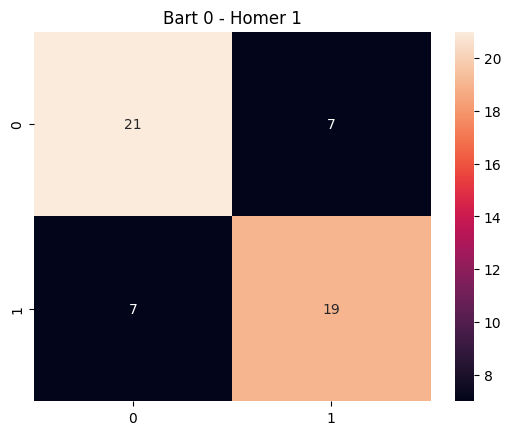

In [298]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(test_dataset.classes, guesses)
plt.title("Bart 0 - Homer 1")
sns.heatmap(cm, annot=True);

In [302]:
from sklearn.metrics import classification_report

print(classification_report(test_dataset.classes, guesses))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        28
           1       0.73      0.73      0.73        26

    accuracy                           0.74        54
   macro avg       0.74      0.74      0.74        54
weighted avg       0.74      0.74      0.74        54



# Implementando Fine-Tunning

* Complemento a transferência de conhecimento entre redes neurais.
* Seleciona algumas camadas das caracterísitcas gerais da rede (Camadas de convolução e max-pooling mais proximas da rede neural densa) para retreinar.

In [309]:
# Altera o treinamento dos pesos para todas as camadas
model.trainable = True

In [313]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer_6 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1

In [311]:
print("Número total camadas: ", len(model.layers))

Número total camadas:  175


In [312]:
# Será aplicado fine_tunning a partir da camada 140
fine_tunning_at = 140

for layer in model.layers[:fine_tunning_at]:
    layer.trainable = False

In [314]:
network.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [316]:
history = network.fit(
    train_dataset,
    epochs=50,
)
network.name = "ResNet50_FineTunning"
path = os.path.join(
    os.getcwd(), 'models', 'simpsons'
)
salvar_modelo(network, path)

Epoch 1/50


2024-07-19 13:42:47.069672: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-19 13:42:47.291456: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-19 13:42:47.291549: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-19 13:42:47.787378: W external/local_tsl/tsl/framework/bfc_

17/27 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.6353 - loss: 8.2690

2024-07-19 13:42:59.703867: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-19 13:42:59.703937: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-19 13:42:59.932987: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 534ms/step - accuracy: 0.6156 - loss: 6.4507
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.6738 - loss: 0.6115
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.6975 - loss: 0.6274
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.6787 - loss: 0.5976
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.7560 - loss: 0.5088
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.7795 - loss: 0.6308
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.7115 - loss: 0.6102
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.8147 - loss: 0.4233
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.8749 - loss: 0.3713
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.8536 - loss: 0.3272
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.7803 - loss: 0.4068
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accurac

Precisão de treinamento:  86.89302325248718 %
Perda de treinamento:  0.3526573809981346


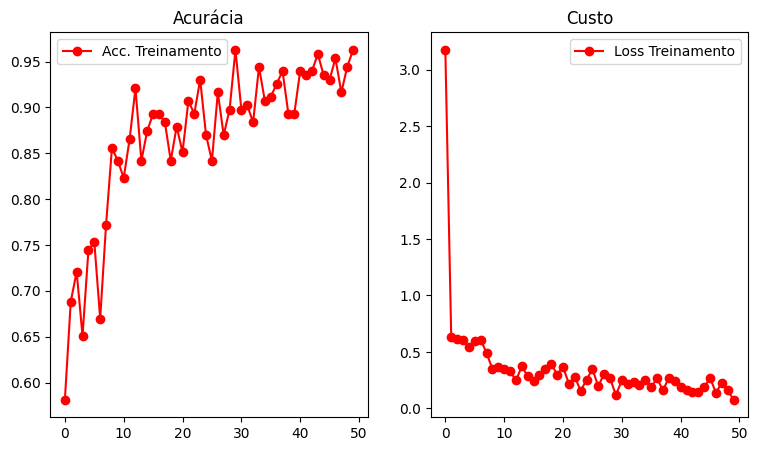

In [318]:
print_history(history)
plot_history(history)

## Avaliando o Fine Tunning

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
Acurácia: 81.48 %
Report de classificação:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83        28
           1       0.86      0.73      0.79        26

    accuracy                           0.81        54
   macro avg       0.82      0.81      0.81        54
weighted avg       0.82      0.81      0.81        54



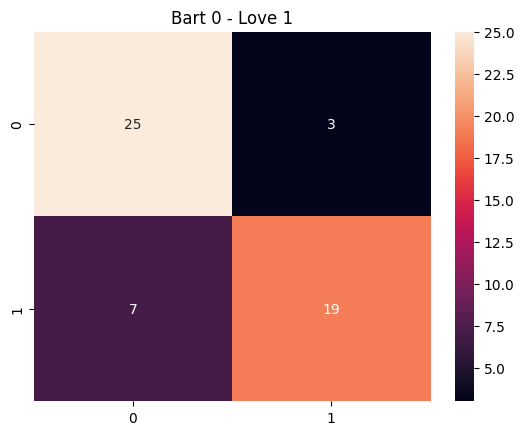

In [317]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate_model(network, dataset):
    guesses = network.predict(dataset)

    # Encontrando a maior probabilidade (pela coluna axis = 1)
    guesses = np.argmax(guesses, axis=1)

    print(f"Acurácia: {round(accuracy_score(dataset.classes, guesses) * 100, 2)} %")
    print("Report de classificação:\n", classification_report(dataset.classes, guesses))
    cm = confusion_matrix(dataset.classes, guesses)
    plt.title("Bart 0 - Love 1")
    sns.heatmap(cm, annot=True);

evaluate_model(network=network, dataset=test_dataset)